In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 10})
import cvxpy as cp
import sklearn

import sys
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
import lcurve_functions as lc

sys.path.append("..")
import regu_test_problems as tp

# A necessidade da regularização. 

Após a análise cuidadosa que efetuamos nas aulas anteriores, temos agora uma boa compreensão das dificuldades associadas aos problemas discretos mal postos e porque é que a solução "ingénua" pode ser inútil. Os métodos de regularização são assim chamados porque impõem regularidade na solução calculada, suprimindo alguns dos componentes de ruído indesejados, levando a soluções aproximadas mais estáveis. Quase todos os métodos de regularização tratados aqui produzem soluções que podem ser expressas como uma expansão SVD. 

# Os principais problemas

A amplitude do fenômeno medido é menor (**e mais sujeita à ruído)** para:
- maiores distâncias da fonte (decaimento natural do fenômeno)
- maiores frequências espaciais no fenômeno de origem (lema de Riemann–Lebesgue)
- As componentes de frequência espacial mais altas estão associadas aos menores valores singulares e, portanto, facilmente corrompidas por ruído.

# Vamos revisitar o problema base da aula passada

O problema inverso básico é baseado na **integral de Fredholm** de primeiro tipo, dada por

\begin{equation}
g(s) = \int_{0}^{1}K(s,t) f(t) \text{d}t
\end{equation}

Neste caso $f(t)$ é a **causa** (o que gostaríamos de inferir), $g(s)$ é o que medimos (**consequência**) e a função $K(s,t)$ é chamado de Kernel, e representa nosso **modelo**. Note que esta equação se parece com uma convolução, se $K(s,t)=h(s-t)$. Assim, o problema inverso pode ser visto como um tipo de **de-convolução**.

Vamos investigar um problema modelo e gerar alguns dados para investigar aspectos teóricos sobre a computação do problema inverso. O problema que queremos investigar é o problema de medir a densidade ao longo do espaço $\rho(x)$, que origina um campo gravitacional medido $g(x')$. Vamos re-escrever a equação acima pra deixá-la mais parecida com nossa notação.

\begin{equation}
g(x') = \int_{0}^{1}K(x',x) \rho(x) \text{d}x
\end{equation}



O campo gravitacional de uma parte infinitesimalmente pequena de $\rho(x)$, de comprimento $\text{d}x$, no eixo $x$ é $\rho(x) \text{d}x / r^2$, em que $r = \sqrt{d^2 + (x' - x)^2}$ é a distância entre o "**ponto fonte**" em $x$ e o "**ponto medido em campo**" em $x'$. A direção do campo gravitacional é no sentido: do "ponto medido em campo" para o "ponto fonte" e, portanto, o valor medido de $\text{d}g(x')$ é

\begin{equation}
\text{d}g(x') = \frac{\text{sin}(\theta)}{r^2}\rho(x) \text{d}x
\end{equation}
com $\text{sin}(\theta) = d/r$. O valor total de $g(x')$ consiste na integral da equação anterior, a saber

\begin{equation}
g(x') = \int_{0}^{1}\frac{d}{(d^2+(x' - x)^2)^{3/2}} \rho(x) \text{d}x
\end{equation}
com 

\begin{equation}
K(x',x) = \frac{d}{(d^2+(x' - x)^2)^{3/2}}
\end{equation}

Note que o **kernel** $K(x',x)$ será usado para computar nossa matriz $\textbf{A}$; a dimensão física da densidade é $\rho(x)$ [kg/m] (1D); falta a constante de gravitação universal, $G$ [Nm$^2$/kg$^2$]. O problema servirá para nos ensinar muitos aspectos. 

Vamos definir funções pra computar a matriz $\textbf{A}$ e o campo de densidades, expresso num vetor $\textbf{x}$, que é a causa do que será de fato medido no vetor $\textbf{b}$. 

In [2]:
# ordem
order = 64
# intervalo de medição
a = 0
b = 1
# distancia medida
d = 0.25
A, x = tp.gravity_model(n = order,a = a, b = b, d = d)
[U,s,V] = lc.csvd(A)


rhox = tp.density_sin(x, 0.5) + 0.5* tp.density_sin(x, 1.0)
gxl = A @ rhox

np.random.seed(0)
n = np.random.normal(loc = 0.0, scale = 0.15, size = len(gxl))
gxln = gxl + n

snr = 20*np.log10(np.linalg.norm(n)/np.linalg.norm(gxln))
print("SNR = {:.2f}".format(snr))

SNR = -29.40


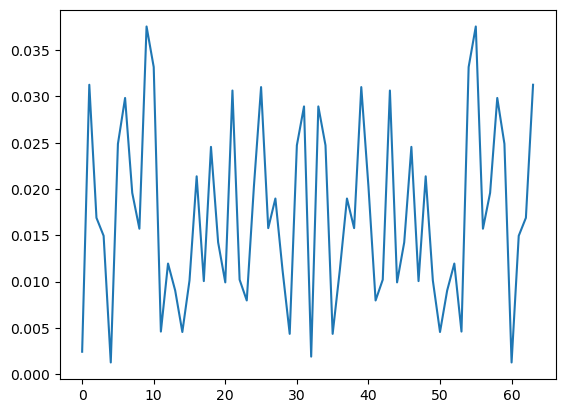

In [3]:
Nf = np.fft.fft(n)
plt.figure()
plt.plot(np.abs(Nf)/len(Nf));

# A condição discreta de Picard
> Seja $\tau$ o nível a partir do qual os valores singulares computados $\sigma_i$ se nivelam devido a erros de arredondamento. A condição de Picard discreta é satisfeita se, para todos os valores $\sigma_i>\tau$, os coeficientes correspondentes $|\textbf{u}_{i}^{T}b|$, em média, decaem mais rapidamente do que os $\sigma_i$.

A solução inversa (ingênua) é expressa por

\begin{equation}
\textbf{x} = \textbf{A}^{-1}\textbf{b} = (\textbf{V} \Sigma^{-1} \textbf{U}^T)\textbf{b}=\sum\limits_{i=1}^{L}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

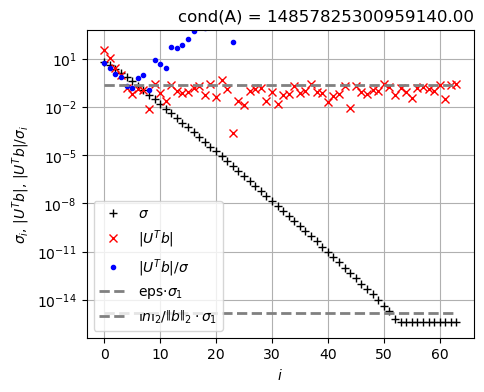

In [4]:
lc.plot_picard(U,s,gxln, noise_norm = np.linalg.norm(n))

# Truncated SVD

Vamos começar com o simples. 

É evidente que os erros extremamente grandes na solução ingênua provêm dos componentes ruidosos da SVD associados aos menores valores singulares (Picard plot). 

A boa notícia é que nossa análise revela que uma parte dos valores singulares é confiável. Particularmente, os componentes para que $|\textbf{u}_{i}^{T}\textbf{b}| / \sigma_i \approx |\textbf{u}_{i}^{T}\textbf{b}_{exa}| / \sigma_i$ (claro, isso é válido se o valor exato da solução satisfizer o critério de Picard - o que é bastante razoável).

Estas considerações conduzem imediatamente a um método de "força bruta" para calcular para calcular soluções aproximadas regularizadas: basta **cortar** os componentes da SVD que são dominados pelo ruído. Assim, definimos a solução SVD truncada (TSVD) $\hat{\textbf{x}}_k$ como a solução obtida mantendo os primeiros $k$ componentes da solução ingénua

\begin{equation}
\hat{\textbf{x}}_k = \sum\limits_{i=1}^{k}\varphi_i\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}
em que 

\begin{equation}
    \varphi_{i}^{[k]} = 
    \begin{cases}
      1 \ \ \ \ \ \ \ i \leq k  \\
      0 \ \ \ \ \ \ \ i > k
    \end{cases}\
\end{equation}

com $k$ escolhido de forma que os componentes ruidosos sejam eliminados. Essa escolha pode ser feita com base na inspeção visual do plot de Picard.

# O caminho de regularização no TSVD

- Quanto maior é $k$, menos regularizado é o problema;
- Quanto menos regularizado, maior é o resíduo da solução - $\left\|\textbf{Ax-b}\right\|^{2}_{2}$ 
- a comunidade de **machine learning** chama isso de **over-fitting** porque o modelo tenta se ajustar bem demais, mas acaba se ajustando ao ruído presente e a solução fica cheia de oscilações;
- Quanto mais regularizado, menor tende a ser a norma da solução $\left\|\textbf{x}\right\|^{2}_{2}$;
- Existe um valor ótimo de $k$, para o qual o $\text{NMSE}$ é o menor - neste caso $k = 10 (12)$ (uma inspeção visual no plot de Picard pode ser muito útil);

Vamos investigar como o problema da gravidade se comporta para várias escolhas de $k$. Computemos também o **Normalized Mean Squared Error**

\begin{equation}
\text{NMSE} = \frac{\left\|\textbf{x}_{exa}-\hat{\textbf{x}}\right\|_{2}^{2}}{\left\|\textbf{x}_{exa}\right\|_{2}^{2}}
\end{equation}

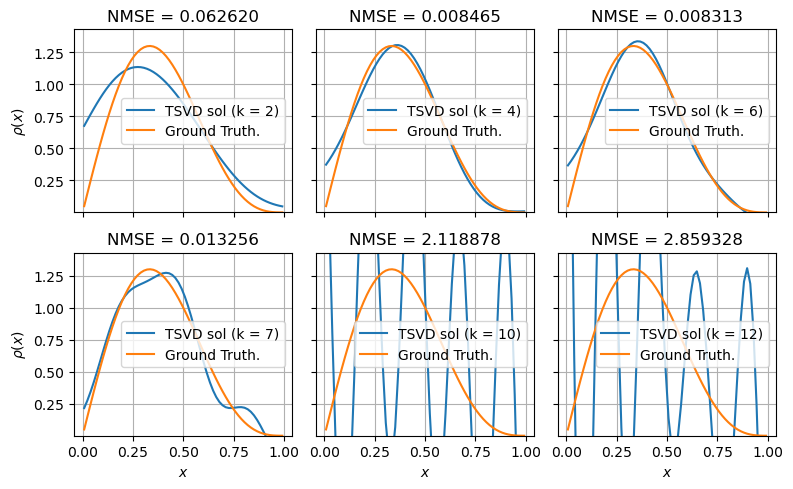

In [5]:
ks = [2, 4, 6, 7, 10, 12]
rhox_k = []
nmse = []
for k in ks:
    xk = lc.tsvd(U, s, V, gxln, k)
    rhox_k.append(xk)
    nmse.append(lc.nmse(xk, rhox))
    
fig, axs = plt.subplots(2, 3, figsize = (8,5), sharex=True, sharey=True)
j = 0
for row in np.arange(2):
    for col in np.arange(3):
        axs[row,col].plot(x, rhox_k[j], label = r'TSVD sol (k = {0:.0f})'.format(ks[j]))
        axs[row,col].plot(x, rhox, label = 'Ground Truth.')
        axs[row,col].set_title(r'NMSE = {0:.6f}'.format(nmse[j]))
        axs[row,col].set_ylim((0.5*np.amin(rhox),1.1*np.amax(rhox)));  
        axs[row,col].grid()
        axs[row,col].legend()
        j += 1
        axs[1,col].set_xlabel(r'$x$')
    axs[row,0].set_ylabel(r'$\rho(x)$')
plt.tight_layout()

# Regularização de Tikhonov

A vantagem do método TSVD é o fato de ser intuitivo e de ser fácil calcular as soluções TSVD $x_k$ para diferentes parâmetros de truncagem, uma vez calculada a SVD. A desvantagem é o fato de requerer explicitamente o cálculo da SVD ou, pelo menos, dos $k$ componentes. Esta tarefa computacional pode ser demasiado pesada para problemas de grande escala, embora às vezes seja difícil escapar dela.

Provavelmente, o método de regularização mais bem sucedido de todos os tempos é a regularização de Tikhonov. Este método foi inventado várias vezes, em várias encarnações (ver Apêndice C do livro); mas o nome de Tikhonov está corretamente associado ao método. De forma semelhante A formulação da TSVD em, o método de Tikhonov incorpora explicitamente o requisito de regularidade na formulação do problema. Especificamente, a solução de Tikhonov é definida como a solução do problema

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \text{min}(\left\|\textbf{Ax-b}\right\|^{2}_{2} + \lambda^2\left\|\textbf{x}\right\|^{2}_{2})
\end{equation}
em que $\lambda>0$ é o parâmetro de regularização que controla os pesos dos dois ingredientes na minimização, a saber

- **Resíduo**: o primeiro termo, $\left\|\textbf{Ax-b}\right\|^{2}_{2}$,  mede a qualidade do ajuste, ou seja, o quão bem a solução, $\hat{\textbf{x}}_{\lambda}$, prevê os dados (ruidosos) $\textbf{b}$. Obviamente, se este termo for demasiado grande, então $\hat{\textbf{x}}_{\lambda}$ não pode ser considerado como uma boa solução porque não "resolve o problema". Por outro lado, intuitivamente, não devemos tornar o resíduo menor do que a dimensão média dos erros em $\textbf{b}$; à semelhança dos problemas de ajuste de dados, não queremos ajustar nosso modelo ao ruído presente nos dados (**over-fiiting**).

- **Norma da solução**: o segundo termo, $\left\|\textbf{x}\right\|^{2}_{2}$, mede a regularidade da solução. A incorporação deste termo baseia-se no nosso conhecimento de que a solução ingênua é dominada por de alta-frequência com grandes amplitudes, e a esperança é portanto que se controlarmos a norma de $\textbf{x}$, então podemos suprimir (a maioria) os componentes de ruído.

## O caminho de regularização na solução de Tikhonov

O equilíbrio entre os dois termos é controlado pelo fator $\lambda^2$ (ou $\lambda$ em alguns livros). Quanto maior o $\lambda$, mais peso é dado à minimização da norma da solução $\left\|\textbf{x}\right\|^{2}_{2}$ e, portanto, à regularidade da solução (notamos que $\left\|\textbf{x}\right\|^{2}_{2}\rightarrow 0$ à medida que $\lambda \rightarrow \infty$ - caminho de regularização). Por outro lado, quanto menor for $\lambda$, mais peso é dado ao ajuste dos dados ruidosos, resultando em soluções menos regulares (obtemos o problema original e a solução "ingénua" por mínimos quadrados quando $\lambda = 0$).

## Solução analítica

Pode-se demonstrar que a solução de Tikhonov tem solução analítica do seguinte problema de mínimos quadrados

\begin{gather}
\hat{\textbf{x}}_{\lambda} = \text{min}\left(\left\|
  \begin{bmatrix}
   \textbf{A} \\ \lambda \textbf{I} 
   \end{bmatrix}
   - 
   \begin{bmatrix}
   \textbf{b} \\ \textbf{0} 
   \end{bmatrix}
   \right\|_{2}\right)
\end{gather}
com soluão dada por:

\begin{equation}
\hat{\textbf{x}}_{\lambda} = (\textbf{A}^T\textbf{A}+\lambda^2\textbf{I})^{-1}\textbf{A}^T \textbf{b}
\end{equation}

**NOTE**: o SVD mantêm as dimensões originais de $\textbf{A}$, enquanto $\textbf{A}^T\textbf{A}$ ($(L \times M) \times (M \times L$)) pode ter uma dimensão bem maior e, portanto, ter um número de condição ainda pior que o problema original. Por isso, as vezes não conseguimos escapar do SVD ou do problema de mínimos quadrados anterior.

Podemos usar a expansão de $\textbf{A}= \textbf{U} \Sigma \textbf{V}^T$ e sua inversa e lembrar que $\textbf{V}^T\textbf{V} = \textbf{I}$. Dessa forma, obtemos

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \textbf{V}(\Sigma^2+\lambda^2\textbf{I})^{-1} \ \Sigma \textbf{U}^T \textbf{b}
\end{equation}

que comparado à

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \sum\limits_{i=1}^{L}\varphi_{i}^{[\lambda]}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}
nos permite inferir que os fatores de filtragem são

\begin{equation}
    \varphi_{i}^{[\lambda]} = \frac{\sigma_{i}^{2}}{\sigma_{i}^{2}+\lambda^2} \approx
    \begin{cases}
      1 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \sigma_i \gg \lambda \\
      \sigma_{i}^{2}/\lambda^2 \ \ \ \ \ \ \ \sigma_i \ll \lambda
    \end{cases}\
\end{equation}

Observemos o que ocorre quando usamos diferentes valores em $\lambda$

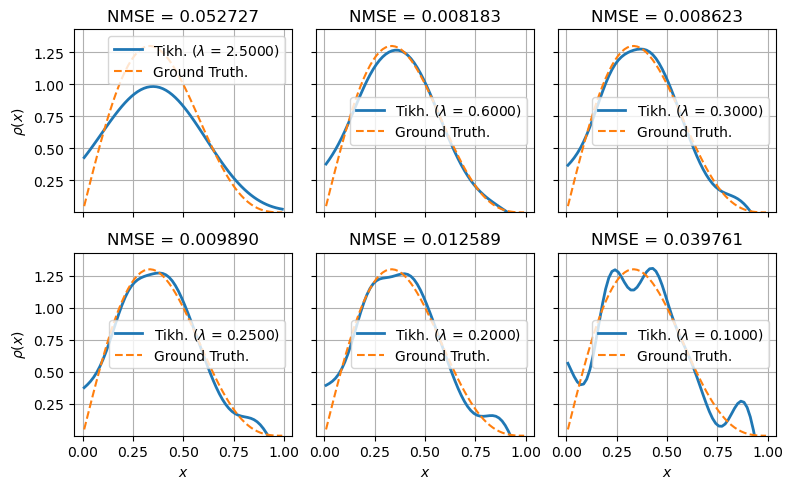

In [7]:
lambdas = [2.5, 0.6, 0.3, 0.25, 0.2, 0.1]
rhox_lam = []
nmse = []
for lam in lambdas:
    xlam = lc.tikhonov(U, s, V, gxln, lam)
    rhox_lam.append(xlam)
    nmse.append(lc.nmse(xlam, rhox))  
    
fig, axs = plt.subplots(2, 3, figsize = (8,5), sharex=True, sharey=True)
j = 0
for row in np.arange(2):
    for col in np.arange(3):
        axs[row,col].plot(x, rhox_lam[j], linewidth = 2, label = r'Tikh. ($\lambda$ = {0:.4f})'.format(lambdas[j]))
        axs[row,col].plot(x, rhox, '--', label = 'Ground Truth.')
        axs[row,col].set_title(r'NMSE = {0:.6f}'.format(nmse[j]))
        axs[row,col].set_ylim((0.5*np.amin(rhox),1.1*np.amax(rhox)));  
        axs[row,col].grid()
        axs[row,col].legend()
        j += 1
        axs[1,col].set_xlabel(r'$x$')
    axs[row,0].set_ylabel(r'$\rho(x)$')
plt.tight_layout()

# A curva L (L-curve)

Analisemos mais de perto a **norma da solução** ($\left\|\textbf{x}\right\|_{2}$) e a **norma residual** ($\left\|\textbf{Ax-b}\right\|_{2}$). Estas normas desempenham um papel central no tratamento prático de problemas discretos mal postos, porque podem sempre ser calculadas independentemente do método de regularização utilizado; não requerem o cálculo da SVD ou de qualquer outra decomposição da matriz, e fornecem uma boa intuição sobre a escolha de $\lambda$.

Vamos calcular $\left\|\textbf{x}\right\|_{2}$ vs. $\left\|\textbf{Ax-b}\right\|_{2}$ para vários valores de $\lambda$ e ver o que acontece em uma escala log-log.

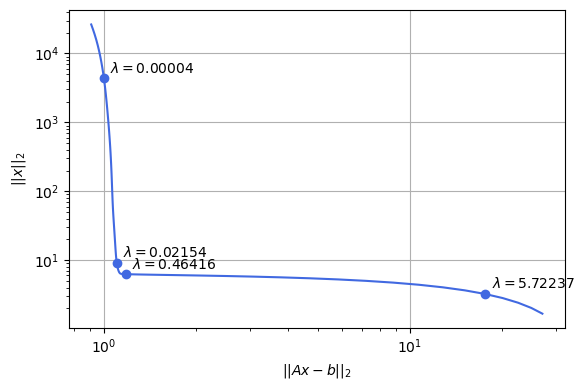

In [9]:
lambdas = np.logspace(-5, 1, num=100)
sol_norms = np.zeros(len(lambdas))
residuals = np.zeros(len(lambdas))
for jl, lam in enumerate(lambdas):
    xlam = lc.tikhonov(U, s, V, gxln, lam)
    sol_norms[jl] = np.linalg.norm(xlam)
    residuals[jl] = np.linalg.norm(A @ xlam - gxln)

listid = [10, 55, 77, 95]
plt.figure(figsize = (6,4))
plt.loglog(residuals, sol_norms, color = 'Royalblue')
plt.loglog(residuals[listid], sol_norms[listid],  'o', color = 'Royalblue')
for num in listid:
    label = r"$\lambda = ${:.5f}".format(lambdas[num])
    plt.annotate(label, (residuals[num], sol_norms[num]), # these are the coordinates to position the label
         textcoords="offset points", # how to position the text
         xytext=(35, 4), # distance from text to points (x,y)
         ha='center') 
plt.grid()
plt.xlabel(r'$||A x - b||_2$')
plt.ylabel(r'$||x||_2$')
plt.tight_layout();

- A curva tem um comportamento típico, que aparece em muitas situações (um "L").

- Quando $\lambda$ é grande demais, então a solução $\hat{\textbf{x}}_{\lambda}$ é sobre-suavizada , já que a norma da solução é muito penalizada na minimização. Este é um caso de **under-fitting** do modelo aos dados medidos.

- Quando $\lambda$ é pequeno demais, então a solução $\hat{\textbf{x}}_{\lambda}$ é sub-suavizada, já que a norma da solução é pouco penalizada na minimização. Este é um caso de **over-fitting** do modelo aos dados medidos - o modelo se ajusta ao ruído.

## A questão que fica é: será que conseguimos achar o valor ótimo de $\lambda$?

- A boa notícia é que **sim** e que há mais de um método.

Além disso, quando calculamos a curva L acima, nós explicitamente computamos diversas soluções do problema, $\hat{\textbf{x}}_{\lambda}$, variando $\lambda$. Isto vai gastar muitos recursos computacionais. Será que temos uma forma mais inteligente de calcular o valor ótimo de $\lambda$?

# Escolhendo $\lambda$ ou $k$

Queremos então uma técnica confiável e automatizada para escolher o parâmetro de regularização, tal como $k$ (para TSVD) ou $\lambda$ (para Tikhonov). Especificamente, o que gostaríamos é ter um método eficiente, robusto e confiável para calcular o parâmetro de regularização a partir dos dados fornecidos, que não requeira inspeção humana humana de um gráfico ou cálculo da SVD (que é inviável para grandes problemas) ou qualquer.

Infelizmente, esse método ainda **não foi encontrado**. O que temos atualmente à nossa disposição é um conjunto de métodos que, sob certos pressupostos, tendem a **funcionar bem**, mas todos eles podem e irão ocasionalmente falhar na produção de bons resultados. O SVD se mostra essencial também.

Não é nossa intenção abranger todos os métodos de escolha de parâmetros desenvolvidos. Em vez disso, concentramo-nos em quatro métodos diferentes, cada um com o seu próprio historico e motivação. Começamos com uma discussão sobre os erros na solução regularizada, que serve de motivação para os métodos de escolha de parâmetros e que conduz naturalmente aos dois primeiros métodos, nomeadamente, o princípio da discrepância (**Discrepancy principle**) e o critério da curva L (**L-curve**). 

Em seguida, descrevemos dois métodos, GCV (**Generalized Cross Validation**) e o método NCP (**Normalized Cumulative Periodgram**), ambos baseados numa descrição estatística do problema. 

## Erros de regularização e perturbação

A solução do problema de Tikhonov pode ser escrita na seguinte forma

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \sum\limits_{i=1}^{L}\varphi_{i}^{[\lambda]}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

Em forma matricial

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \textbf{V}\Phi^{[\lambda]}\Sigma^{-1}\textbf{U}^T \textbf{b}
\end{equation}
com $\Phi^{[\lambda]}_{ij} = \text{diag}(\varphi_1, \varphi_2, \cdots, \varphi_L)$ e 

\begin{equation}
\varphi_{i}^{[\lambda]} = \frac{\sigma_{i}^{2}}{\sigma_{i}^{2} + \lambda^2}
\end{equation}
Para TSVD essa matriz é feita de 1s e 0s.

Recordamos agora que o lado direito consiste num "sinal" exato $+$ mais ruído aditivo: $\textbf{b} = \textbf{A}\textbf{x}_{exa} + \textbf{n}$. Segue-se que o erro na solução regularizada de Tikhonov é dado por


\begin{equation}
\textbf{x}_{exa} - \hat{\textbf{x}}_{\lambda} =\textbf{x}_{exa} -  \textbf{V}\Phi^{[\lambda]}\Sigma^{-1}\textbf{U}^T \textbf{b}\\
\textbf{x}_{exa} - \hat{\textbf{x}}_{\lambda} = \textbf{x}_{exa} -  \textbf{V}\Phi^{[\lambda]}\Sigma^{-1}\textbf{U}^T (\textbf{A}\textbf{x}_{exa}) - \textbf{V}\Phi^{[\lambda]}\Sigma^{-1}\textbf{U}^T \textbf{n}\\
\textbf{x}_{exa} - \hat{\textbf{x}}_{\lambda} = (\textbf{I}-\textbf{V}\Phi^{[\lambda]}\Sigma^{-1}\textbf{U}^T \textbf{U} \Sigma \textbf{V}^{T})\textbf{x}_{exa} - \textbf{V}\Phi^{[\lambda]}\Sigma^{-1}\textbf{U}^T \textbf{n}\\
\textbf{x}_{exa} - \hat{\textbf{x}}_{\lambda} = \textbf{V}(\textbf{I}-\Phi^{[\lambda]})\textbf{V}^T \ \textbf{x}_{exa}-\textbf{V}\Phi^{[\lambda]}\Sigma^{-1}\textbf{U}^T \textbf{n}
\end{equation}

A diferença $\textbf{x}_{exa} - \hat{\textbf{x}}_{\lambda}$ possui, portanto dois termos:

- **bias**
- **ruído**

O primeiro termo (**bias**) é dado por

\begin{equation}
\Delta x_{bias} = \textbf{V}(\textbf{I}-\Phi^{[\lambda]})\textbf{V}^T \ \textbf{x}_{exa} = \sum\limits_{i=1}^{L}(1-\varphi^{[\lambda]}_{i})(\textbf{v}^{T}_{i}\textbf{x}_{exa})\textbf{v}_{i}
\end{equation}

Note que este erro aumenta com o aumento do parâmetro de regularização, já que o valor dos filtros, $\varphi^{[\lambda]}$, diminui. Isto corresponde ao erro **under fitting** ou ao menor valor da norma da solução, $\left\|\textbf{x}\right\|^{2}_{2}$ com o aumento de $\lambda$.

O segundo termo se deve ao **ruído**, e é dado por

\begin{equation}
\Delta x_{pert} = \textbf{V}\Phi^{[\lambda]}\Sigma^{-1}\textbf{U}^T \textbf{n} = \sum\limits_{i=1}^{L}\varphi^{[\lambda]}_{i}\frac{\textbf{u}^{T}_{i}\textbf{n}}{\sigma_i}\textbf{v}_{i}
\end{equation}

Note que este erro aumenta com a diminuição do parâmetro de regularização, já que o valor dos filtros, $\varphi^{[\lambda]}$, aumenta, o que contribui para a amplificação do ruído $\textbf{n}$. Isto corresponde ao erro **over fitting**.

Tanto os erros de bias e ruído estão sempre presentes na solução regularizada, e a sua dimensão depende do parâmetro de regularização. Para TSVD, Se $k$ for próximo de $L$, então a maioria dos componentes da SVD são incluídos e o **bias** é pequeno, mas o erro de **ruído** é grande porque aplicamos pouca filtragem. Por outro lado, se $k$ for pequeno, então muitos componentes da SVD são deixados de fora e, assim, o erro de **ruído** também será pequeno, mas o erro de **bias** será grande. Por conseguinte, podemos dizer que o objetivo da escolha de $k$ é equilibrar a dimensão dos dois termos de erro $\Delta x_{bias}$ e $\Delta x_{pert}$.

O mesmo é verdade para a escolha do parâmetro de regularização de Tikhonov. Se $\lambda$ for muito pequeno, então todos os fatores de filtro $\varphi^{[\lambda]}_{i}$ estão próximos de $1$. Portanto, $\Phi^{[\lambda]} \approx \textbf{I}$, e o erro de **bias** é pequeno (enquanto o erro de **ruído** é grande). E se $\lambda$ for grande, então muitos fatores de filtragem são pequenos, e assim o erro associado ao **ruído** será também pequeno, mas então $\Phi^{[\lambda]}$ não está perto da matriz identidade, e o erro de **bias** será grande.

Idealmente, a escolha automática do parâmetro de regularização visa equilibrar $\Delta x_{bias}$ e $\Delta x_{pert}$ sempre presentes na solução.

# A lógica geral dos métodos

Seguindo o princípio do equilíbrio entre **bias** e **ruído** e a intuição dada na análise da curva L, vamos precisar das seguintes quantidades:

\begin{equation}
\begin{gathered}
\left\|x_{\lambda}\right\|_{2}^{2}=\sum_{i=1}^{L}\left(\varphi_{i}^{[\lambda]} \frac{\textbf{u}_{i}^{T} \textbf{b}}{\sigma_{i}}\right)^{2}, \\
\left\|A x_{\lambda}-b\right\|_{2}^{2}=\sum_{i=1}^{L}\left(\left(1-\varphi_{i}^{[\lambda]}\right) \textbf{u}_{i}^{T} \textbf{b}\right)^{2}
\end{gathered}
\end{equation}

O que queremos fazer é encontrar $\lambda$ que minimiza uma dada função de regularização, $R(\lambda)$. O que usaremos são os dados ruidosos em $\textbf{b}$ e a expansão em SVD de $\textbf{A}$ ($\textbf{U}$, $\Sigma$, $\textbf{V}$). Queremos fazer isso **sem computar** a solução do problema diversas vezes.

A lógica geral dos métodos que veremos é a seguinte:

1. Computamos $\beta = \textbf{U}^{T} \textbf{b}$ & $r = \left\|\textbf{b}\right\|^{2}_{2} -  \left\|\textbf{U}^{T} \textbf{b}\right\|^{2}_{2}$ (isto servirá no escalonamento numérico do problema)

2. Inicializamos $\lambda$ e $R(\lambda)$ com zeros (e.g. $npts = 200$ zeros)

3. Preenchemos o último valor de $\lambda$ com $\lambda[-1] = \text{max}(s[-1], s[0]*tol)$ (e.g. $tol = 16*eps$)

4. Computamos uma razão numérica dada por: $\text{ratio} = \left(\frac{\sigma[0]}{\lambda[-1]}\right)^{1/(npts-1)}$

5. Preenchemos $\lambda$ do final para o início com: $\lambda[-2] = \text{ratio} \lambda[-1]$, $\lambda[-3] = \text{ratio} \lambda[-2]$, $\cdots$, $\lambda[0] = \text{ratio} \lambda[1]$. Isto faz com que a escala em $\lambda$ seja preenchida razoavelmente de acordo com a razão entre o maior e menor valor singulares do problema

6. De posse dos valores **discretos** em $\lambda$, computamos a versão **discreta** $R(\lambda)$ - em geral, usando $\textbf{U}$, $\Sigma$, $\textbf{V}, \textbf{b}$

7. Achamos o valor mínimo dessa função discreta $R(\lambda)$ e computamos dois valores para servir de constrição. O $\lambda$ ideal estará entre estes dois valores

8. Usamos um algoritmo de otimização para encontrar o valor ideal de $\lambda$.

# Discrepancy principle (simplicidade)

Vamos começar pelo mais simples e intuitivo. Talvez isso seja mais um resgate do que uma apresentação completa de algo novo. Vou adiantar que este método não é muito utilizado. Podemos olhar o método tanto do ponto de vista de TSVD, quanto da solução de Tikhnov.

No caso de TSVD o método diz que devemos escolher o parâmetro de truncagem $k$ de modo a que a norma residual seja igual à "discrepância" nos dados, medida por $\upsilon_{\text{DP}}\left\|\textbf{n}\right\|_{2}$. É raro que a relação possa ser satisfeita exatamente, pelo que, em vez disso, escolhemos

\begin{equation}
\text{Escolha} \ \ \ k  \ \ \ \text{Tal que} \ \ \ \left\|\textbf{A}\textbf{x}_k-\textbf{b}\right\|_{2}\geq\upsilon_{\text{DP}}\left\|\textbf{n}\right\|_{2}
\end{equation}

A mesma estratégia pode ser usada para o método de Tikhonov, a saber

\begin{equation}
\text{Escolha} \ \ \ \lambda  \ \ \ \text{Tal que} \ \ \ \left\|\textbf{A}\textbf{x}_{\lambda}-\textbf{b}\right\|_{2} = \upsilon_{\text{DP}}\left\|\textbf{n}\right\|_{2}
\end{equation}

A principal desvantagem do DP é que muitas vezes não conhecemos o ruído, $\textbf{n}$, com exatidão. Infelizmente, a qualidade do parâmetro de regularização calculado é muito sensível à exatidão da estimativa de $\left\|\textbf{n}\right\|_{2}$. Em particular, uma estimativa demasiado pequena pode levar a um dramático over fitting (porque $k$ é é escolhido demasiado grande e $\lambda$ é pequeno demais). 

Não vou entrar nos detalhes da programação aqui, mas você pode checar por si só.

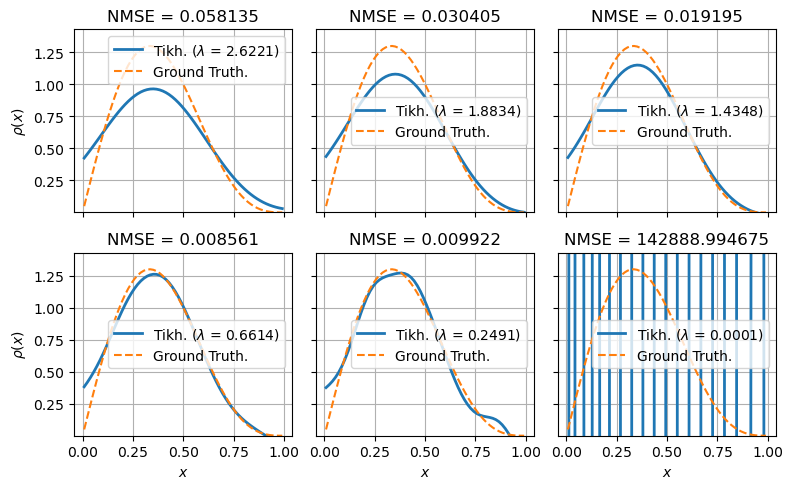

In [10]:
vdps = [5, 3, 2, 1, 0.9, 0.8]
rhox_dp = []
lam_dps = []
nmse = []
for vdp in vdps:
    x_dp, lam_dp = lc.discrep(U, s, V, gxln, vdp*np.linalg.norm(n))
    #x_dp = lc.tikhonov(U, s, V.T, gxln, lam_dp[0])
    rhox_dp.append(x_dp.flatten())
    lam_dps.append(lam_dp[0])
    nmse.append(lc.nmse(x_dp.flatten(), rhox))  
    
fig, axs = plt.subplots(2, 3, figsize = (8,5), sharex=True, sharey=True)
j = 0
for row in np.arange(2):
    for col in np.arange(3):
        axs[row,col].plot(x, rhox_dp[j], linewidth = 2, label = r'Tikh. ($\lambda$ = {0:.4f})'.format(lam_dps[j]))
        axs[row,col].plot(x, rhox, '--', label = 'Ground Truth.')
        axs[row,col].set_title(r'NMSE = {0:.6f}'.format(nmse[j]))
        axs[row,col].set_ylim((0.5*np.amin(rhox),1.1*np.amax(rhox)));  
        axs[row,col].grid()
        axs[row,col].legend()
        j += 1
        axs[1,col].set_xlabel(r'$x$')
    axs[row,0].set_ylabel(r'$\rho(x)$')
plt.tight_layout()
#print(r'$\lambda = $ {}'.format(lam_dps))

# L-curve

Continuamos a utilizar a SVD como ferramenta de análise e analisamos mais de perto a norma da solução e a norma residual correspondente. Estas normas desempenham um papel central no tratamento prático de problemas discretos mal-postos, porque podem sempre ser calculadas independentemente do método de regularização utilizado, não requerem o cálculo da SVD ou de qualquer outra decomposição da matriz.

A norma da solução TSVD e o resíduo associado variam monotonicamente com $k$, como se pode ver pelas expressões

\begin{equation}
\begin{gathered}
\left\|x_{k}\right\|_{2}^{2}=\sum_{i=1}^{k}\left(\frac{\textbf{u}_{i}^{T} \textbf{b}}{\sigma_{i}}\right)^{2} \leq\left\|x_{k+1}\right\|_{2}^{2}, \\
\left\|A x_{k}-b\right\|_{2}^{2}=\sum_{i=k+1}^{n}\left(\textbf{u}_{i}^{T} \textbf{b}\right)^{2}+\varepsilon_{\perp}^{2} \geq\left\|A x_{k+1}-b\right\|_{2}^{2},
\end{gathered}
\end{equation}
em que $\varepsilon_{\perp}=\left\|\left(I-U U^{T}\right) \textbf{b}\right\|_{2}$ é a norma do componente de $\textbf{b}$ que se encontra fora do espaço de colunas de $\textbf{A}$. De forma semelhante, a norma da solução de Tikhonov e o seu resíduo são dados por

\begin{equation}
\begin{gathered}
\left\|x_{\lambda}\right\|_{2}^{2}=\sum_{i=1}^{n}\left(\varphi_{i}^{[\lambda]} \frac{\textbf{u}_{i}^{T} \textbf{b}}{\sigma_{i}}\right)^{2}, \\
\left\|A x_{\lambda}-b\right\|_{2}^{2}=\sum_{i=1}^{n}\left(\left(1-\varphi_{i}^{[\lambda]}\right) \textbf{u}_{i}^{T} \textbf{b}\right)^{2}+\varepsilon_{\perp}^{2},
\end{gathered}
\end{equation}

Vamos introduzir a notação

\begin{equation}
\xi=\left\|\textbf{x}_{\lambda}\right\|_{2}^{2} \quad \text { & } \quad \rho=\left\|\textbf{A} \textbf{x}_{\lambda}-\textbf{b}\right\|_{2}^{2} .
\end{equation}

\begin{equation}
\hat{\xi}=\log \left\|x_{\lambda}\right\|_{2}^{2} \quad \text { & } \quad \hat{\rho}=\log \left\|A x_{\lambda}-b\right\|_{2}^{2}
\end{equation}

Vimos que a curva L desempenha um papel interessante na análise. Vamos construir uma  função de regularização baseada na **curvatura** da curva L. Para isso, vamos precisar das derivadas, a saber

\begin{equation}
\begin{gathered}
\xi^{\prime} \equiv \frac{d \xi}{d \lambda}=-\frac{4}{\lambda} \sum_{i=1}^{n}\left(1-\varphi_{i}^{[\lambda]}\right)\left(\varphi_{i}^{[\lambda]}\right)^{2} \frac{\left(\textbf{u}_{i}^{T} \textbf{b}\right)^{2}}{\sigma_{i}^{2}}, \\
\rho^{\prime} \equiv \frac{d \rho}{d \lambda}=\frac{4}{\lambda} \sum_{i=1}^{n}\left(1-\varphi_{i}^{[\lambda]}\right)^{2} \varphi_{i}^{[\lambda]}\left(\textbf{u}_{i}^{T} \textbf{b}\right)^{2}=-\lambda^{2} \xi^{\prime} .
\end{gathered}
\end{equation}

\begin{equation}
\hat{\xi}^{\prime}=\frac{\xi^{\prime}}{\xi} \quad \text { & } \quad \hat{\rho}^{\prime}=\frac{\rho^{\prime}}{\rho} .
\end{equation}

Vemos que $\xi^{\prime}<0$ e $\rho^{\prime}>0$ para todo $\lambda$, confirmando a monotonicidade das normas como funções de $\lambda$. Além disso, a partir da relação $\rho^{\prime}=-\lambda^{2} \xi^{\prime}$ obtemos $d \xi / d \rho=-\lambda^{-2}$, mostrando que a norma de solução ao quadrado $\left\|x_{\lambda}\right\|_{2}^{2}$ é uma função monotonicamente decrescente da norma residual ao quadrado $\left\|A x_{\lambda}-b\right\|_{2}^{2}$. Uma vez que a função da raiz quadrada é monotónica, o mesmo é verdade para as próprias normas.

Existe também uma relação simples entre as segundas derivadas de $\xi$ e $\rho$. Especificamente, temos

\begin{equation}
\rho^{\prime \prime} \equiv \frac{d^{2} \rho}{d \lambda^{2}}=\frac{d}{d \lambda}\left(-\lambda^{2} \xi^{\prime}\right)=-2 \lambda \xi^{\prime}-\lambda^{2} \xi^{\prime \prime},
\end{equation}

em que $\xi^{\prime \prime} \equiv d^{2} \xi / d \lambda^{2}$. 

\begin{equation}
\hat{\xi}^{\prime \prime}=\frac{\xi^{\prime \prime} \xi-\left(\xi^{\prime}\right)^{2}}{\xi^{2}} \quad \text { & } \quad \hat{\rho}^{\prime \prime}=\frac{\rho^{\prime \prime} \rho-\left(\rho^{\prime}\right)^{2}}{\rho^{2}} .
\end{equation}

Considere-se agora a curva obtida quando traçamos $\xi$ vs. $\rho$, com $\lambda$ como parâmetro. A **curvatura**, $c_{\lambda}$, desta curva, em função de $\lambda$ é dada por

\begin{equation}
c_{\lambda}=\frac{\rho^{\prime} \xi^{\prime \prime}-\rho^{\prime \prime} \xi^{\prime}}{\left(\left(\rho^{\prime}\right)^{2}+\left(\xi^{\prime}\right)^{2}\right)^{3 / 2}}=\frac{2 \lambda\left(\xi^{\prime}\right)^{2}}{\left(\left(\rho^{\prime}\right)^{2}+\left(\xi^{\prime}\right)^{2}\right)^{3 / 2}},
\end{equation}


\begin{equation}
c_{\lambda}=2 \frac{\xi \rho}{\xi^{\prime}} \frac{\lambda^{2} \xi^{\prime} \rho+2 \lambda \xi \rho+\lambda^{4} \xi \xi^{\prime}}{\left(\lambda^{2} \xi^{2}+\rho^{2}\right)^{3 / 2}},
\end{equation}

E na escala log-log

\begin{equation}
\hat{c}_{\lambda}=2 \frac{\hat{\rho}^{\prime} \hat{\xi}^{\prime \prime}-\hat{\rho}^{\prime \prime} \hat{\xi}^{\prime}}{\left(\left(\hat{\rho}^{\prime}\right)^{2}+\left(\hat{\xi}^{\prime}\right)^{2}\right)^{3 / 2}},
\end{equation}



Podemos então, fazer o seguinte:

\begin{equation}
\text{Escolha} \ \ \ \lambda  \ \ \ \text{para minimizar} \ \ \ -\hat{c}_{\lambda}
\end{equation}

Concluímos esta discussão sobre o critério da curva $L$ com algumas palavras de cautela. O critério é essencialmente heurístico, e não há garantia de que que produzirá sempre um bom parâmetro de regularização. Um exemplo em que o critério da curva $L$ é suscetível de falhar é quando $\textbf{x}_{exa}$ é muito suave (dominado pelos primeiros vectores singulares à direita). O canto da curva L está localizado no ponto em que a norma da solução passa a ser dominada pelos componentes ruidosos da SVD. Parece um contra-senso, mas nestes casos o parâmetro de regularização tende a ser subestimado, conduzindo a uma solução menos suave que a solução exata.

Outro exemplo em que o critério da curva $L$ pode falhar é quando a alteração das normas residual e da solução é pequena. Neste caso, é difícil achar o canto da curva $L$ com precisão. Infelizmente este comportamento dos coeficientes é frequentemente observado em problemas de grande escala.

Uma última observação crítica sobre o comportamento do critério da curva $L$: se $\left\|n\right\|_{2}\rightarrow 0$, então o parâmetro de regularização, $\lambda_L$ tende a divergir do ótimo. Este comportamento indesejável de não-convergência não é partilhado pelo princípio da discrepância (ou GCV, discutido a seguir). Felizmente, $\left\|n\right\|_{2}\rightarrow 0$ é uma situação rara na prática.

C:\Users\Cliente\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


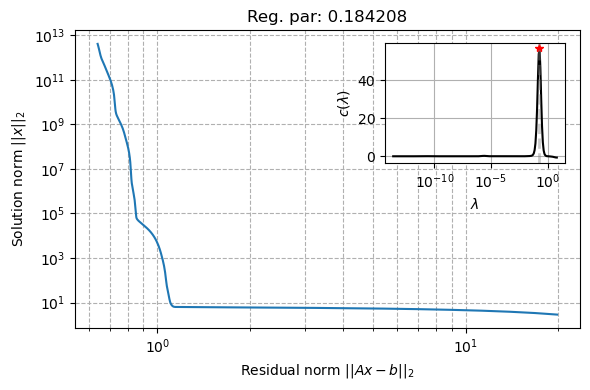

In [11]:
lam_lc = lc.l_curve(U, s, gxln, plotit = True)

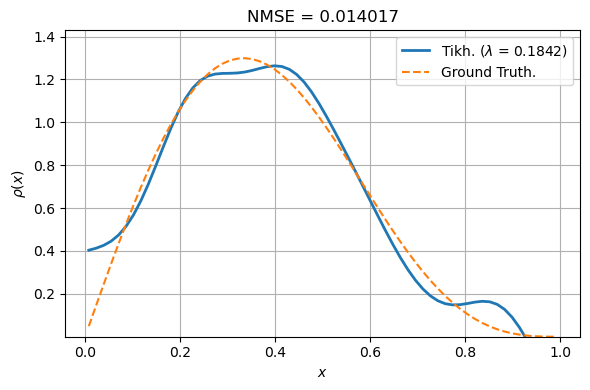

In [12]:
x_lc = lc.tikhonov(U, s, V, gxln, lam_lc[0])
nmse_lc = lc.nmse(x_lc, rhox)  

plt.figure(figsize = (6,4))
plt.plot(x, x_lc, linewidth = 2, label = r'Tikh. ($\lambda$ = {0:.4f})'.format(lam_lc[0]))
plt.plot(x, rhox, '--', label = 'Ground Truth.')
plt.title(r'NMSE = {0:.6f}'.format(nmse_lc))
plt.ylim((0.5*np.amin(rhox),1.1*np.amax(rhox)));  
plt.grid()
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$')
plt.tight_layout()

# Generalized cross-validation

Este é um método estatístico, no qual queremos prever $\textbf{b}_{exa}$ (o qual não possuímos) usando uma técnica de validação de dados.

Em **cross validation**, separam-se os elementos do nosso lado direito, $\textbf{b}$, em dois conjuntos e utiliza-se um dos conjuntos para calcular a solução, que é depois utilizada para prever os elementos do outro conjunto. Por exemplo, podemos omitir $b_i$, o $i$-ésimo elemento de $\textbf{b}$, e depois calcular a solução de Tikhonov com base no problema reduzido. O objetivo é escolher o parâmetro de regularização $\lambda$ de forma a minimizar os erros de previsão para todos os elementos de dados

\begin{equation}
\lambda = \text{min}\left(\frac{1}{m}\left(\sum\limits_{i=1}^{m}A(i,:)x_{\lambda}-b_i\right)^{2}\right)
\end{equation}

Este, no entanto, é um problema difícil de resolver porque envolve a computação de $m$ soluções de Tikhonov, o que é computacionalmente muito custoso. No método de **generalized cross validation (GCV)**, a computação das $m$ soluções é substituída por uma solução média, em que a minimização se torna:

\begin{equation}
\text{Escolha} \ \ \ \lambda  \ \ \ \text{para minimizar} \ \ \ G(\lambda) = \frac{\left\|\textbf{A}\textbf{x}_{\lambda}-\textbf{b}\right\|_{2}}{\left(m-\sum\limits_{i=1}^{L}\varphi^{[\lambda]}_{i}\right)^{2}}=\frac{\sum\limits_{i=1}^{n}\left(\left(1-\varphi_{i}^{[\lambda]}\right) \textbf{u}_{i}^{T} \textbf{b}\right)^{2}}{\left(m-\sum\limits_{i=1}^{L}\varphi^{[\lambda]}_{i}\right)^{2}}
\end{equation}

Para TSVD

\begin{equation}
\text{Escolha} \ \ \ k  \ \ \ \text{para minimizar} \ \ \ G(\lambda) = \frac{\left\|\textbf{A}\textbf{x}_{k}-\textbf{b}\right\|_{2}}{(m-k)^{2}}
\end{equation}

A experiência mostra que este método de escolha de parâmetros é bastante robusto e exato, desde que o ruído seja branco (porque este pressuposto está subjacente à derivação da função GCV). O método pode falhar ocasionalmente, é claro, resultando num **over-fitting**. Adicionar um peso $w$ antes da soma no denominador pode ajudar a diminuir o problema, mas é uma solução heurística (tentativa e erro).


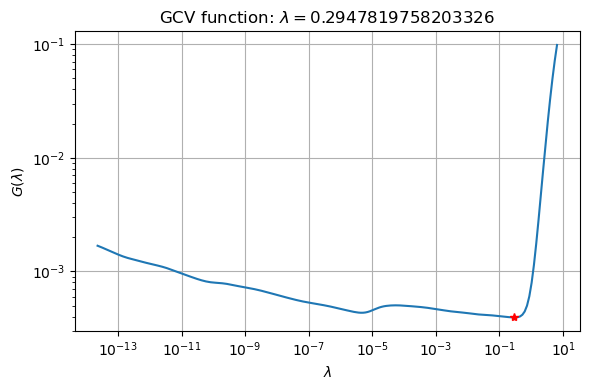

In [13]:
lam_gcv = lc.gcv_lambda(U, s, gxln, print_gcvfun = True)

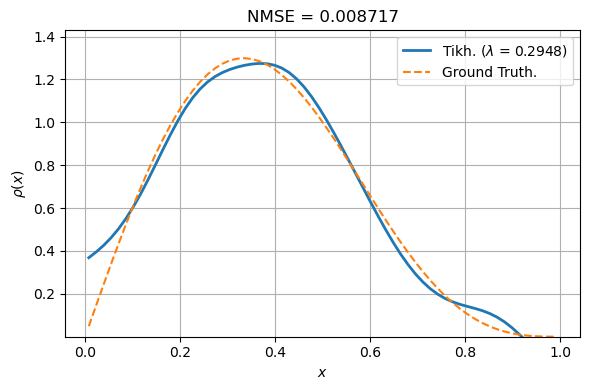

In [14]:
x_gcv = lc.tikhonov(U, s, V, gxln, lam_gcv)
nmse_gcv = lc.nmse(x_gcv, rhox)  

plt.figure(figsize = (6,4))
plt.plot(x, x_gcv, linewidth = 2, label = r'Tikh. ($\lambda$ = {0:.4f})'.format(lam_gcv))
plt.plot(x, rhox, '--', label = 'Ground Truth.')
plt.title(r'NMSE = {0:.6f}'.format(nmse_gcv))
plt.ylim((0.5*np.amin(rhox),1.1*np.amax(rhox)));  
plt.grid()
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$')
plt.tight_layout()

# NCP (Normalized Cumulative Periodogram)


O método descrito aqui consiste em ver o vetor residual como uma série temporal e considerar o lado direito exato $\textbf{b}_{exa}$ (que sabemos representar uma função suave) como um "sinal" que distintamente diferente do vetor de ruído $\textbf{n}$. O objetivo é, portanto, encontrar o parâmetro de regularização para o qual o resíduo, $\textbf{Ax}-\textbf{b}$, muda de comportamento.

A ideia é semelhante ao princípio da discrepância (DP), com o qual escolhemos o parâmetro de regularização de modo a que a norma do resíduo seja igual à norma do ruído. Em DP, a única informação que utilizamos sobre $\textbf{n}$ é o seu desvio padrão, $\eta$, ou sua norma, $\left\|\textbf{n}\right\|_{2}$. 

Agora, pretendemos desenvolver um critério mais sofisticado, baseado em estatística. A pergunta é: que partes do vetor residual, $\textbf{Ax}-\textbf{b}$, podem ser consideradas como ruído? 

A transformada discreta de Fourier (DFT) permite-nos responder a esta questão para o caso importante do ruído branco, por meio de uma técnica que tem sido desenvolvida tanto no processamento de sinais como na estatística (usando nomenclatura diferente, claro). Seja $\hat{r}_{\lambda}$ a DFT do vetor residual de Tikhonov $r_{\lambda}$,

\begin{equation}
\hat{r}_{\lambda}=\operatorname{DFT}\left(r_{\lambda}\right)=\left(\left(\hat{r}_{\lambda}\right)_{0},\left(\hat{r}_{\lambda}\right)_{1}, \ldots,\left(\hat{r}_{\lambda}\right)_{M-1}\right)^{T} \in \mathbb{C}^{M} .
\end{equation}

A DFT é sempre calculada por meio do algoritmo da transformada rápida de Fourier (FFT), computacionalmente eficiente. O espectro de potência de $r_{\lambda}$ é definido como o vetor real

\begin{equation}
p_{\lambda}=\left(\left|\left(\hat{r}_{\lambda}\right)_{0}\right|^{2},\left|\left(\hat{r}_{\lambda}\right)_{1}\right|^{2}, \ldots,\left|\left(\hat{r}_{\lambda}\right)_{q}\right|^{2}\right)^{T}, \quad q=\lfloor m / 2\rfloor
\end{equation}
em que $q$ denota o maior número inteiro tal que $q \leq M / 2$. Os elementos do espectro de potência $p_{\lambda} \in \mathbb{R}^{q+1}$ representam a potência no sinal em cada um dos componentes espectrais básicos, com o primeiro componente $\left(p_{\lambda}\right)_{0}$ a representar a componente DC e o último componente $\left(p_{\lambda}\right)_{q+1}$ a representar a frequência mais elevada.

Definimos agora o **Normalized Cumulative Periodogram** (NCP) como o vetor $c\left(r_{\lambda}\right) \in \mathbb{R}^{q}$ cujos elementos envolvem as somas acumuladas do espectro de potência:

\begin{equation}
c\left(r_{\lambda}\right)_{i}=\frac{\left(p_{\lambda}\right)_{1}+\cdots+\left(p_{\lambda}\right)_{i+1}}{\left(p_{\lambda}\right)_{1}+\cdots+\left(p_{\lambda}\right)_{q+1}}, \quad i=1, \ldots, q
\end{equation}


A normalização garante que o maior elemento é $c\left(r_{\lambda}\right)_{q}=1$. Note que o primeiro componente de $p_{\lambda}$ não é incluído no cálculo do NCP.

Desde que o ruído seja branco (Gaussiano), podemos utilizar o NCP como base para um método de escolha de parâmetros, porque ele revela precisamente quando o vetor residual pode ser considerado ruído branco. Obtemos um critério de escolha de parâmetros  robusto se escolhermos o parâmetro de regularização para o qual o vetor residual mais se assemelha a ruído branco, no sentido em que o NCP está mais próximo de uma **linha reta**. Podemos medir isto com a norma 2 entre o NCP e o vetor, $c_{\text{white}}$, de ruído branco, com solução analítica dada por


\begin{equation}
c_{\text{white}}=(1 / q, 2 / q, \ldots, 1)^{T}
\end{equation}

Assim, para escolher $\lambda$ fazemos

\begin{equation}
\text{Escolha} \ \ \ \lambda  \ \ \ \text{para minimizar} \ \ \ d(\lambda)=\left\|c\left(r_{\lambda}\right)-c_{\text {white }}\right\|_{2}
\end{equation}

Para a TSVD

\begin{equation}
\text{Escolha} \ \ \ k  \ \ \ \text{para minimizar} \ \ \ d(k)=\left\|c\left(r_{k}\right)-c_{\text {white }}\right\|_{2}
\end{equation}

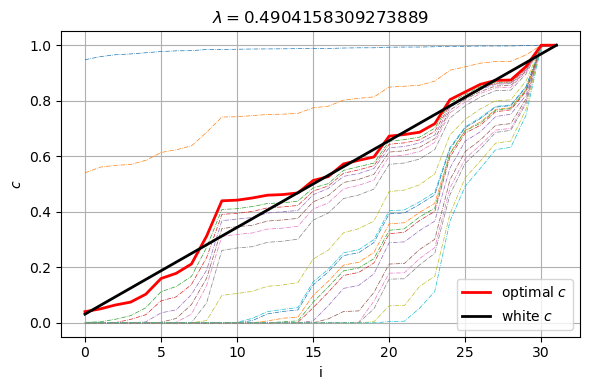

In [15]:
lam_ncp, dist = lc.ncp(U, s, gxln, printncp=True)

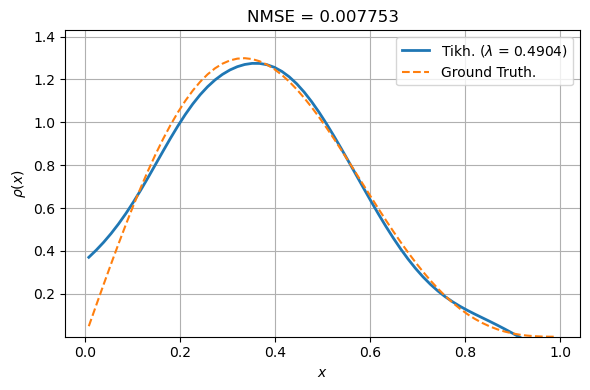

In [16]:
x_ncp = lc.tikhonov(U, s, V, gxln, lam_ncp)
nmse_ncp = lc.nmse(x_ncp, rhox)  

plt.figure(figsize = (6,4))
plt.plot(x, x_ncp, linewidth = 2, label = r'Tikh. ($\lambda$ = {0:.4f})'.format(lam_ncp))
plt.plot(x, rhox, '--', label = 'Ground Truth.')
plt.title(r'NMSE = {0:.6f}'.format(nmse_ncp))
plt.ylim((0.9*np.amin(rhox),1.1*np.amax(rhox)));  
plt.grid()
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$')
plt.tight_layout()

# Testando outros solvers

Vamos usar o parâmetro obtido por GCV e testar os solvers CVX e Ridge (Sklearn)

C:\Users\Cliente\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


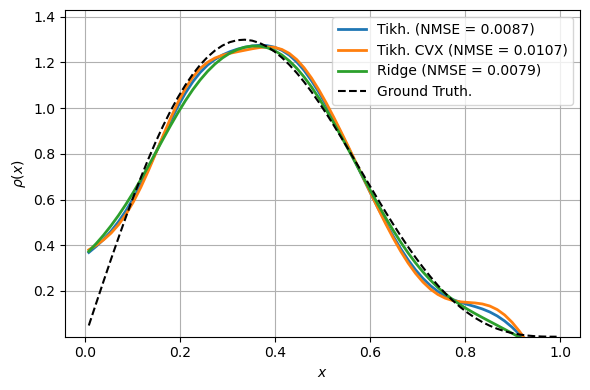

In [17]:
# CVX
x_gcv_cvx = lc.cvx_tikhonov(A, gxln, lam_gcv, l_norm = 2)
nmse_cvx = lc.nmse(x_gcv_cvx, rhox)

# Ridge
regressor = sklearn.linear_model.Ridge(alpha=lam_gcv, fit_intercept = False, solver = 'svd')
x_gcv_ridge = regressor.fit(A, gxln).coef_
nmse_ridge = lc.nmse(x_gcv_ridge, rhox)

plt.figure(figsize = (6,4))
plt.plot(x, x_gcv, linewidth = 2, label = r'Tikh. (NMSE = {0:.4f})'.format(nmse_gcv))
plt.plot(x, x_gcv_cvx, linewidth = 2, label = r'Tikh. CVX (NMSE = {0:.4f})'.format(nmse_cvx))
plt.plot(x, x_gcv_ridge, linewidth = 2, label = r'Ridge (NMSE = {0:.4f})'.format(nmse_ridge))
plt.plot(x, rhox, '--k', label = 'Ground Truth.')
plt.ylim((0.5*np.amin(rhox),1.1*np.amax(rhox)));  
plt.grid()
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$')
plt.tight_layout()

# Reconstrução

Em algumas situações é desejado que nós reconstruamos uma quantidade desejada em posições que não medimos. Por exemplo, no caso do problema investigado aqui, podemos medir a aceleração da gravidade $g(x')$ a uma distância $d = 0.25$ m da fonte. Note que:

- $d = 0$ m representa uma origem hipotética do campo de densidades. É o nosso termo fonte e, usualmente, não conseguimos reconstruir nada que para $d<0$ (nossa área de reconstrução não deve **conter fontes**);
- Mas podemos reconstruir $g(x')$ para $d = 0.10$ m ou  $d = 0.5$ m

A reconstrução é um problema direto. Note que já computamos $\textbf{x}$ pelo problema inverso regularizado. Precismos então computar

\begin{equation}
\textbf{b}_{\text{r}} = \textbf{A}_{\text{r}} \hat{\textbf{x}}
\end{equation}
em que $\textbf{A}_{\text{r}}$ é a matriz de reconstrução avaliada nas posições desejadas.

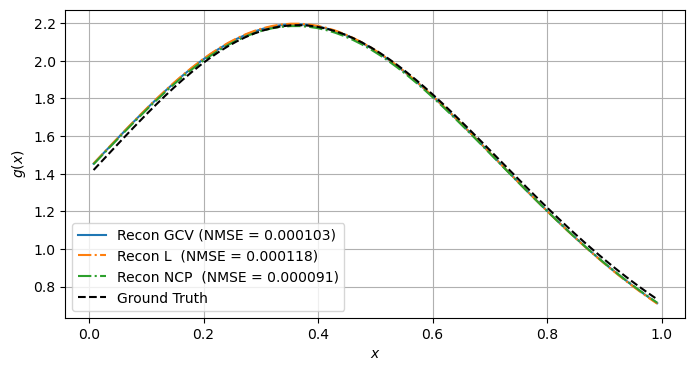

In [18]:
# distancia desejada
dr = 0.5

# Matriz de reconstrução
Ar, xr = tp.gravity_model(n = order,a = a, b = b, d = dr)

# Ground Truth
gxt = Ar @ rhox

# reconstruido GCV
gx_gcv = Ar @ x_gcv
nmse_gcv = lc.nmse(gx_gcv, gxt)

# reconstruido L-curve
gx_lc = Ar @ x_lc
nmse_lc = lc.nmse(gx_lc, gxt)

# reconstruido NCP
gx_ncp = Ar @ x_ncp
nmse_ncp = lc.nmse(gx_ncp, gxt)

############ Figure ###########################
plt.figure(figsize = (8,4))
plt.plot(x, gx_gcv, label = 'Recon GCV (NMSE = {0:.6f})'.format(nmse_gcv))
plt.plot(x, gx_lc, '-.', label = 'Recon L  (NMSE = {0:.6f})'.format(nmse_lc))
plt.plot(x, gx_ncp, '-.', label = 'Recon NCP  (NMSE = {0:.6f})'.format(nmse_ncp))
plt.plot(x, gxt, '--k', label = 'Ground Truth')
plt.legend()
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$g(x)$');

# Export para matlab (para testes)

In [36]:
import scipy.io
file_path = 'gravity_64.mat'
scipy.io.savemat(file_path, {'A': A,
                            'x': x,
                            'rhox': rhox,
                            'n': n,
                            'gxl': gxl,
                            'gxln' : gxln})